# SML 301

## Session 9: The Kernel Trick

* Learning Rates
* AUROC
* Game: Tanks!
* Support Vector Machines

    * linear kernel
    * polynomial kernel
    * radial basis functions

In [194]:
# install packages (if need be)
#%pip install palmerpenguins

In [4]:
#import needed libraries
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.model_selection as skm

from matplotlib.pyplot import figure, plot, grid, title, xlabel, ylabel, legend
from palmerpenguins import load_penguins
from sklearn import svm
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.model_selection import GridSearchCV, train_test_split
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve

# load data
penguins = load_penguins()
penguins['gentoo_bool'] = np.where(penguins['species'] == 'Gentoo', 1, 0)

# https://stackoverflow.com/questions/28716241/controlling-the-threshold-in-logistic-regression-in-scikit-learn
def custom_predict(X, threshold):
    probs = model.predict_proba(X) 
    return (probs[:, 1] > threshold).astype(int)

C:\Users\freex\AppData\Local\Programs\Python\Python313\Lib\site-packages\palmerpenguins\penguins.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


# Euler's Method

to solve a boundary value problem
$$\frac{du}{dt} = f(t, u(t), \quad a \leq t \leq b, \quad u(a) = u_{0}$$

* adapted from demo by Brenton le Mesurier
* https://lemesurierb.people.charleston.edu/introduction-to-numerical-methods-and-analysis-python/main/ODE-IVP-1-basics-and-Euler-python.html

In [1]:
def eulerMethod(f, a, b, u_0, n):
    """Solve du/dt = f(t, u) for t in [a, b], with initial value u(a) = u_0"""
    h = (b-a)/n
    t = np.linspace(a, b, n+1)  # Note: "n" counts steps, so there are n+1 values for t.
    u = np.empty_like(t)
    u[0] = u_0
    for i in range(n):
        u[i+1] = u[i] + f(t[i], u[i])*h
    return (t, u)

## Example

$$\frac{du}{dt} = -\sin(u), \quad 0 \leq t \leq 3, \quad u(0) = 3$$

In [2]:
# right hand side
def f1(t, u):
    """For integration of -sin(x)
    The general solution is
        u(t) = cos(x) + C,
        C = u_0 - cos(a)
    """
    return -np.sin(t)

# true solution
def u1(t, a, u_0):
    return np.cos(t) + (u_0 - np.cos(a));

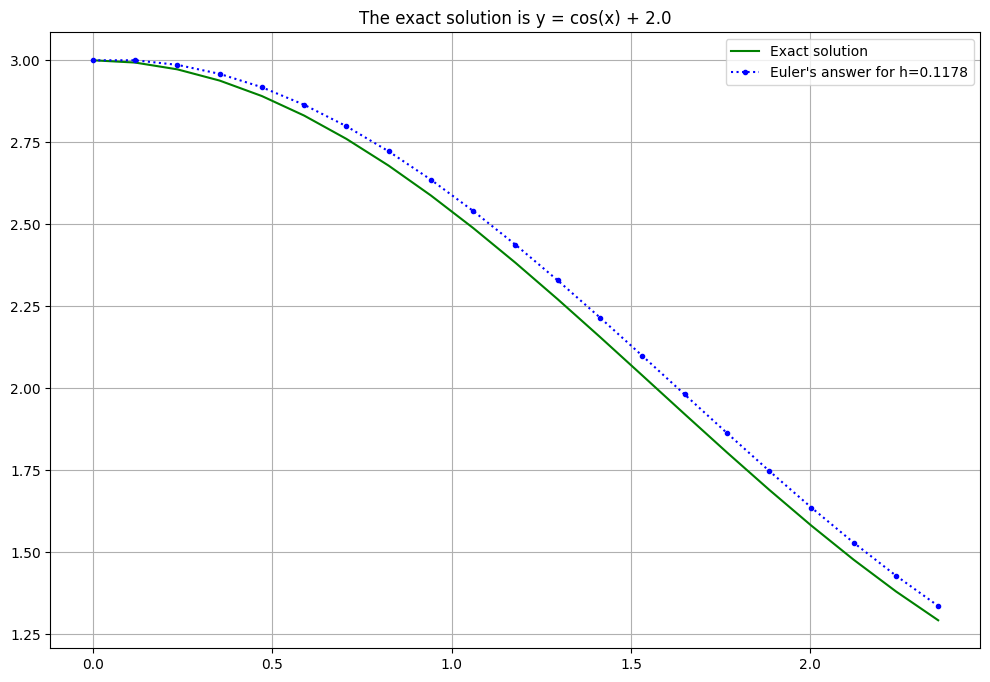

In [5]:
a = 0.
b = 3/4*np.pi
u_0 = 3.
n = 20

(t, U) = eulerMethod(f1, a, b, u_0, n)
u = u1(t, a, u_0)

figure(figsize=[12,8])
title(f"The exact solution is y = cos(x) + {u_0 - np.cos(a)}")
plot(t, u, "g", label="Exact solution")
plot(t, U, ".:b", label=f"Euler's answer for h={(b-a)/n:0.4g}")
legend()
grid(True);

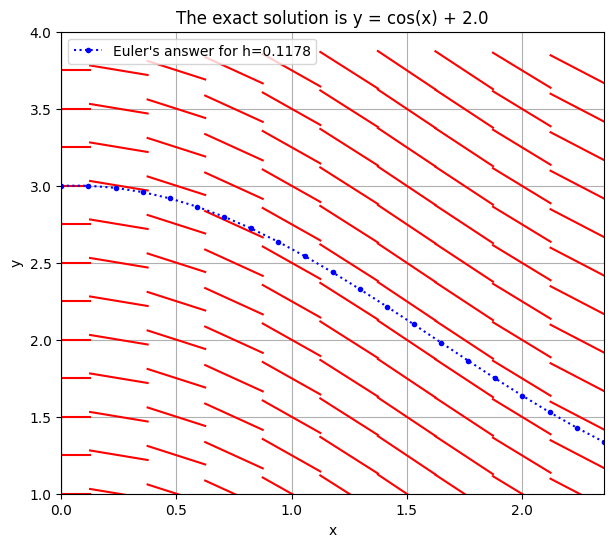

In [6]:
a = 0.
b = 3/4*np.pi
u_0 = 3.
n = 20

# vector field code: https://andrewcharlesjones.github.io/journal/differential-equation-viz.html
mesh_width = 0.25
dir_field_x_template = np.linspace(-mesh_width / 2, mesh_width / 2, 100)
xlims = [a, b]
ylims = [1, 4]
def dydx(x, y):
    return -np.sin(x)

(t, U) = eulerMethod(f1, a, b, u_0, n)
u = u1(t, a, u_0)

plt.figure(figsize=(7, 6))
plt.xlim(xlims)
plt.ylim(ylims)
plt.axvline(0, c="black")
plt.axhline(0, c="black")

for x in np.arange(xlims[0], xlims[1], mesh_width):
    for y in np.arange(ylims[0], ylims[1], mesh_width):
        curr_slope = dydx(x, y)
        curr_intercept = y - curr_slope * x
        dir_field_xs = dir_field_x_template + x
        dir_field_ys = [curr_slope * dfx + curr_intercept for dfx in dir_field_xs]
        plt.plot(dir_field_xs, dir_field_ys, color="red")
plt.xlabel("x")
plt.ylabel("y")
plt.title("dy/dx")
#figure(figsize=[12,8])
title(f"The exact solution is y = cos(x) + {u_0 - np.cos(a)}")
#plot(t, u, "g", label="Exact solution")
plot(t, U, ".:b", label=f"Euler's answer for h={(b-a)/n:0.4g}")
legend()
grid(True);

## Example

$$\frac{du}{dt} = 3.01u, \quad 0 \leq t \leq 2, \quad u(0) = 0.42$$

* tip: try out different values for $n$ (number of steps)

<positron-console-cell-7>:20: SyntaxWarning: invalid escape sequence '\,'
<positron-console-cell-7>:20: SyntaxWarning: invalid escape sequence '\,'


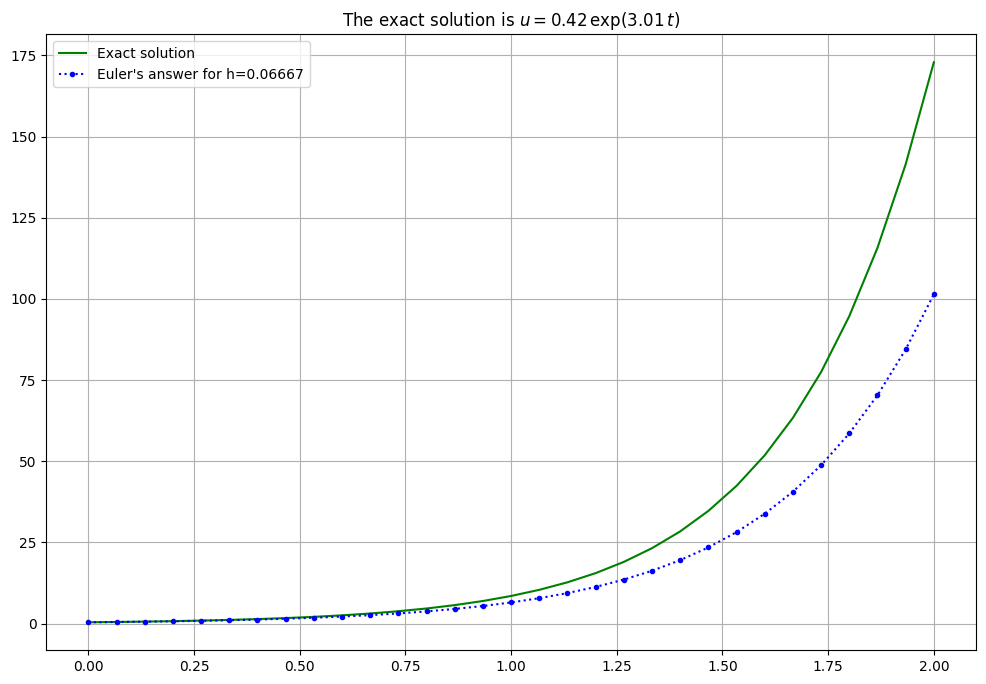

In [7]:
def f2(t, u):
    """For solving du/dt = k u.
    The variable k may be defined later, so long as that is done before this function is used.
    """
    return k*u

def u2(t, a, u_0, k):
    return u_0 * np.exp(k*(t-a));

k = 3.01
u_0 = 0.42
a = 0.
b = 2.
n = 30 #number of steps

(t, U) = eulerMethod(f2, a, b, u_0, n)
u = u2(t, a, u_0, k)

figure(figsize=[12,8])
title(f"The exact solution is $u = {u_0} \, \exp({k} \, t)$")
plot(t, u, "g", label="Exact solution")
plot(t, U, ".:b", label=f"Euler's answer for h={(b-a)/n:0.4g}")

legend()
grid(True);

# Shooting Methods

$$\frac{d^{2}y}{dt^{2}} = -g$$

$$y(0) = 0, \quad y(5) = 42$$

$$y'(0) = ?$$

* We are trying to estimate the initial muzzle velocity $y'(0)$
* gravity: $g = 9.8$
* adapted from textbook: https://pythonnumericalmethods.studentorg.berkeley.edu/notebooks/Index.html



In [8]:
F = lambda t, s: \
  np.dot(np.array([[0,1],[0,-9.8/s[1]]]),s)

t_span = np.linspace(0, 5, 100)
y0 = 0 #left initial condition

## Activity: Fire!

Try out different values of $v_{0}$ to try to hit the red dot target

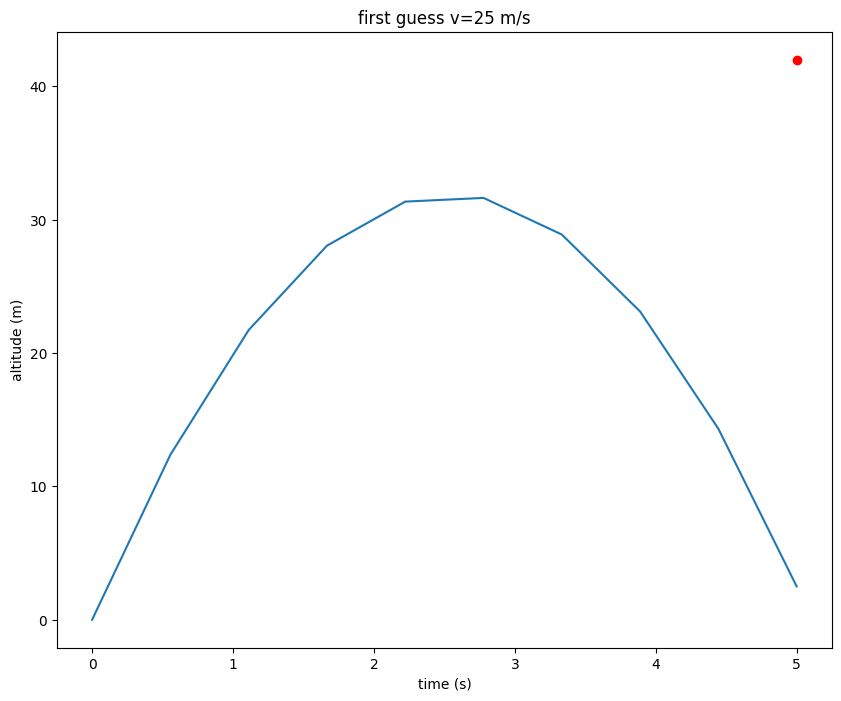

In [9]:
v0 = 25 #try out different valiues for initial muzzle velocity
t_eval = np.linspace(0, 5, 10)
sol = solve_ivp(F, [0, 5], \
                [y0, v0], t_eval = t_eval)

plt.figure(figsize = (10, 8))
plt.plot(sol.t, sol.y[0])
plt.plot(5, 42, 'ro') #right initial condition
plt.xlabel('time (s)')
plt.ylabel('altitude (m)')
plt.title(f'first guess v={v0} m/s')
plt.show()

# AUROC

## Area under the ROC (radio operator characteristic) curve

* FPR: false positive rate = $\frac{FP}{FP + TN}$, aka type I errors
* TPR: true positive rate = $\frac{TP}{TP + FN}$, aka power

https://en.wikipedia.org/wiki/Sensitivity_and_specificity

In [196]:
df = penguins[['gentoo_bool', 'body_mass_g']] #load in needed columns
df = df.dropna() #then remove missing data
X = df[['body_mass_g']] #explanatory variables
y = df['gentoo_bool'] #target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 301)

model = LogisticRegression().fit(X_train, y_train)
pred_proba_df = pd.DataFrame(model.predict_proba(X_test)) #data frame of probabilities (of being "negative" == 0 or "positive" == 1)

## Thresholds

By default, logistic regression makes classification decisions at 0.5 (on the vertical axis).  However, the researcher might want to adjust the threshold level to restrict (or permit) misclassifications.

### Default (threshold = 0.5)

In [197]:
y_pred = custom_predict(X=X_test, threshold=0.5)
confusion_mat = confusion_matrix(y_test, y_pred)
print(confusion_mat)

TP = confusion_mat[1,1]
FN = confusion_mat[1,0]
FP = confusion_mat[0,1]
TN = confusion_mat[0,0]

fpr = FP / (FP + TN)
tpr = TP / (TP + FN)
print(f'FPR: {fpr:.4f}')
print(f'TPR: {tpr:.4f}')

[[63  4]
 [ 8 28]]
FPR: 0.0597
TPR: 0.7778


C:\Users\freex\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


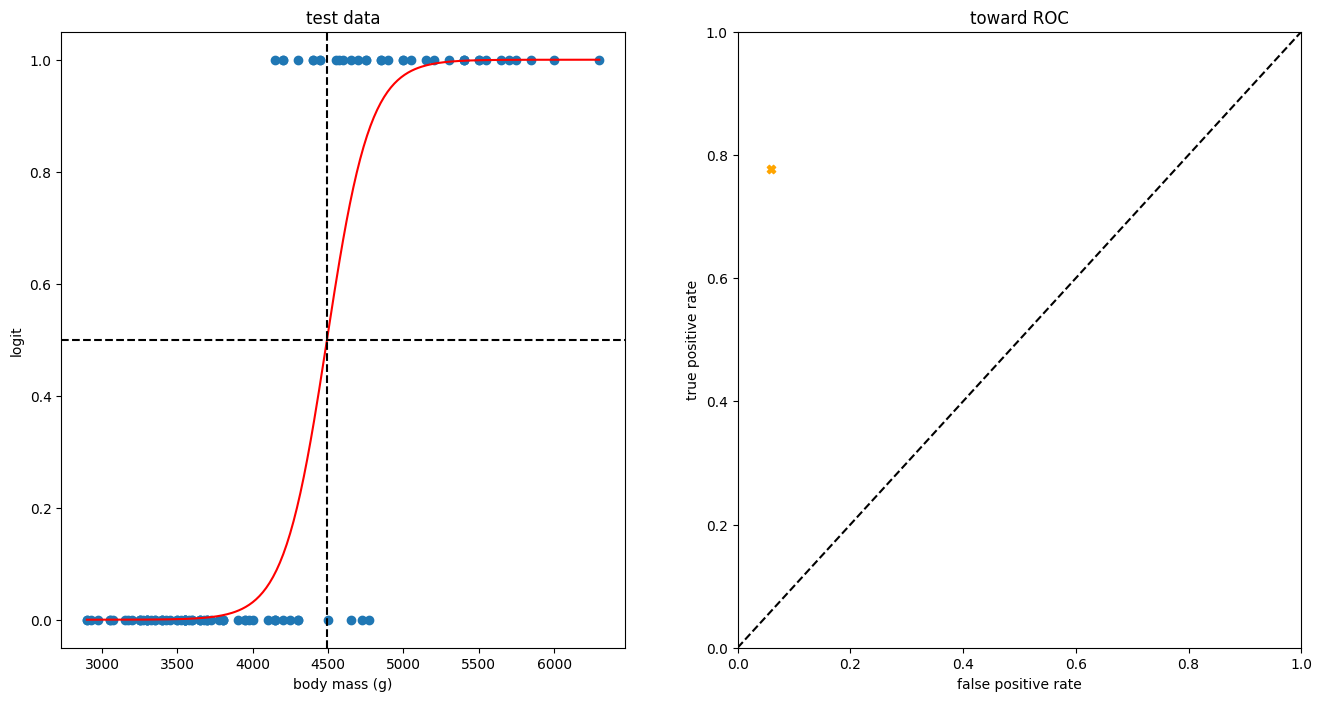

In [198]:
log_curve_x = np.linspace(X_test.min(), X_test.max(), 301).reshape(-1,1)
log_curve_y = model.predict_proba(log_curve_x)[:,1]
beta_0 = model.intercept_[0]
beta_1 = model.coef_[0][0]
cutoff_x = -beta_0 / beta_1
cutoff_y = 0.5


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.scatter(X_test['body_mass_g'], y_test)
ax1.plot(log_curve_x, log_curve_y, color = "red")
ax1.axhline(y = cutoff_y, color = "black", linestyle = "--")
ax1.axvline(x = cutoff_x, color = "black", linestyle = "--")
ax1.set_title("test data")
ax1.set_xlabel("body mass (g)")
ax1.set_ylabel("logit")

ax2.plot([0,1], [0,1], linestyle = "--", color = "black")
ax2.scatter(fpr, tpr, color = "orange", marker = "X")
ax2.set_title("toward ROC")
ax2.set_xlabel("false positive rate")
ax2.set_ylabel("true positive rate")
ax2.set_xlim(0,1)
ax2.set_ylim(0,1)

plt.show()

## lower threshold, fewer false negatives

In [199]:
y_pred = custom_predict(X=X_test, threshold=0.2)
confusion_mat = confusion_matrix(y_test, y_pred)
print(confusion_mat)

TP = confusion_mat[1,1]
FN = confusion_mat[1,0]
FP = confusion_mat[0,1]
TN = confusion_mat[0,0]

fpr = FP / (FP + TN)
tpr = TP / (TP + FN)
print(f'FPR: {fpr:.4f}')
print(f'TPR: {tpr:.4f}')

[[61  6]
 [ 3 33]]
FPR: 0.0896
TPR: 0.9167


C:\Users\freex\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


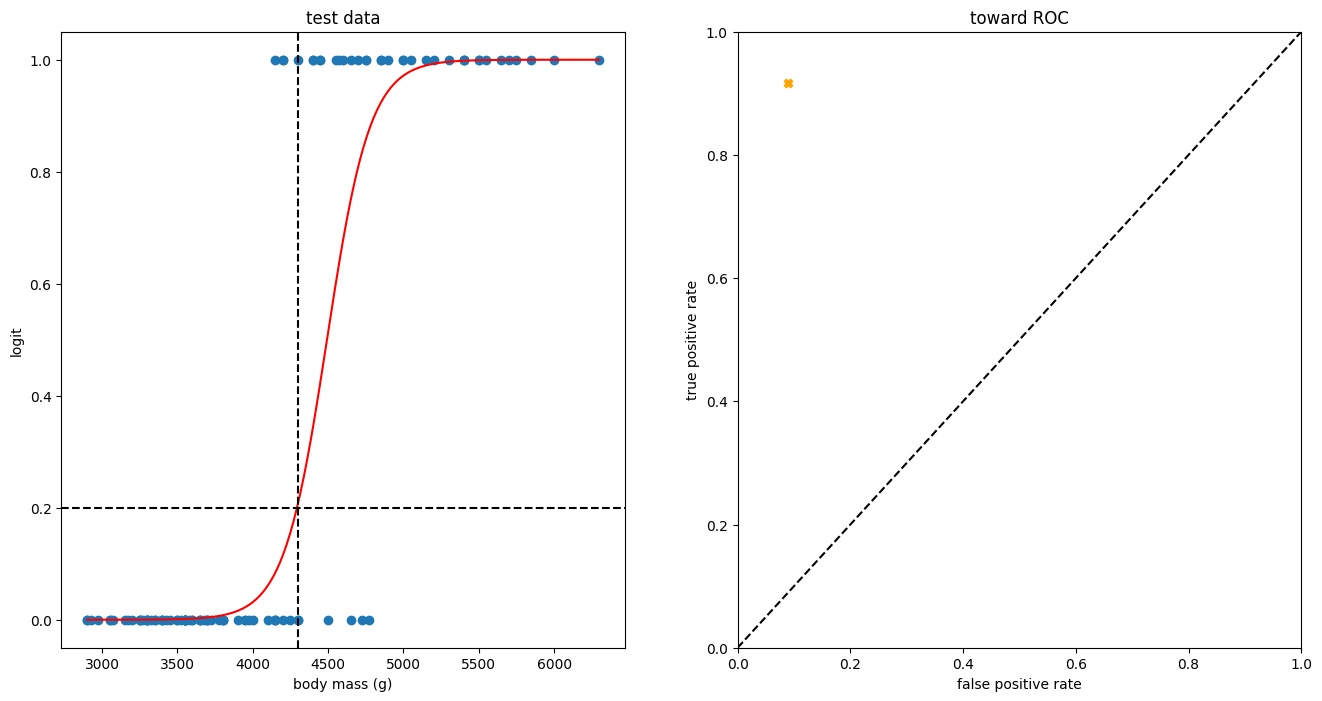

In [200]:
log_curve_x = np.linspace(X_test.min(), X_test.max(), 301).reshape(-1,1)
log_curve_y = model.predict_proba(log_curve_x)[:,1]
beta_0 = model.intercept_[0]
beta_1 = model.coef_[0][0]
cutoff_x = 4300 #TODO: not hard-code this
cutoff_y = 0.2


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.scatter(X_test['body_mass_g'], y_test)
ax1.plot(log_curve_x, log_curve_y, color = "red")
ax1.axhline(y = cutoff_y, color = "black", linestyle = "--")
ax1.axvline(x = cutoff_x, color = "black", linestyle = "--")
ax1.set_title("test data")
ax1.set_xlabel("body mass (g)")
ax1.set_ylabel("logit")

ax2.plot([0,1], [0,1], linestyle = "--", color = "black")
ax2.scatter(fpr, tpr, color = "orange", marker = "X")
ax2.set_title("toward ROC")
ax2.set_xlabel("false positive rate")
ax2.set_ylabel("true positive rate")
ax2.set_xlim(0,1)
ax2.set_ylim(0,1)

plt.show()

## higher threshold, fewer false positives

In [201]:
y_pred = custom_predict(X=X_test, threshold=0.8)
confusion_mat = confusion_matrix(y_test, y_pred)
print(confusion_mat)

TP = confusion_mat[1,1]
FN = confusion_mat[1,0]
FP = confusion_mat[0,1]
TN = confusion_mat[0,0]

fpr = FP / (FP + TN)
tpr = TP / (TP + FN)
print(f'FPR: {fpr:.4f}')
print(f'TPR: {tpr:.4f}')

[[65  2]
 [12 24]]
FPR: 0.0299
TPR: 0.6667


C:\Users\freex\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


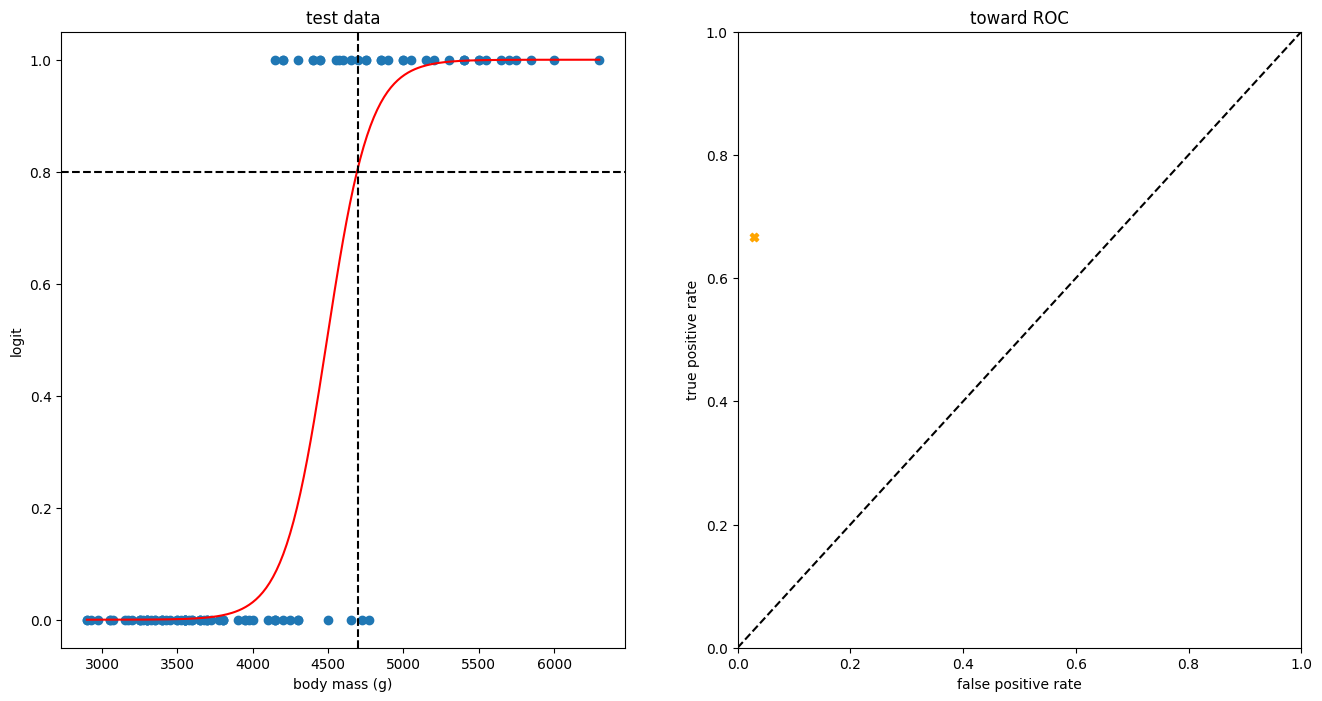

In [202]:
log_curve_x = np.linspace(X_test.min(), X_test.max(), 301).reshape(-1,1)
log_curve_y = model.predict_proba(log_curve_x)[:,1]
beta_0 = model.intercept_[0]
beta_1 = model.coef_[0][0]
cutoff_x = 4700 #TODO: not hard-code this
cutoff_y = 0.8


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.scatter(X_test['body_mass_g'], y_test)
ax1.plot(log_curve_x, log_curve_y, color = "red")
ax1.axhline(y = cutoff_y, color = "black", linestyle = "--")
ax1.axvline(x = cutoff_x, color = "black", linestyle = "--")
ax1.set_title("test data")
ax1.set_xlabel("body mass (g)")
ax1.set_ylabel("logit")

ax2.plot([0,1], [0,1], linestyle = "--", color = "black")
ax2.scatter(fpr, tpr, color = "orange", marker = "X")
ax2.set_title("toward ROC")
ax2.set_xlabel("false positive rate")
ax2.set_ylabel("true positive rate")
ax2.set_xlim(0,1)
ax2.set_ylim(0,1)

plt.show()

## ROC

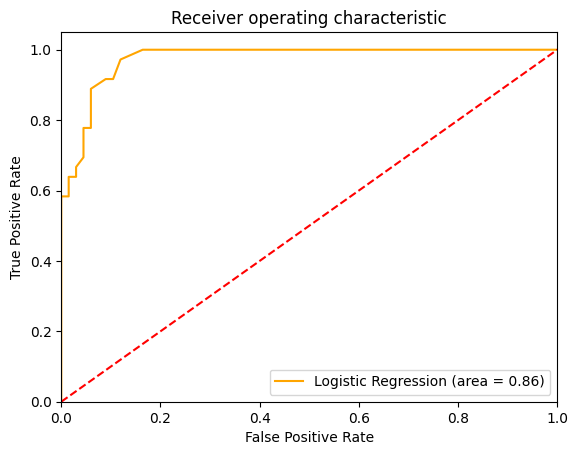

In [203]:
logit_roc_auc = roc_auc_score(y_test, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, color = "orange", label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()

TODO: show AUROC gets better (i.e. closer to 1.0) with more input variables

In [204]:
# fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))

# roc_curve_1_var = RocCurveDisplay.from_estimator(model, X_test, y_test, ax = ax1, name = "one variable")

# plt.show()

# Support Vector Machines

## demo code by Carolina Bento

https://medium.com/towards-data-science/support-vector-machines-explained-with-python-examples-cb65e8172c85

## adapted by Derek Sollberger for SML 301

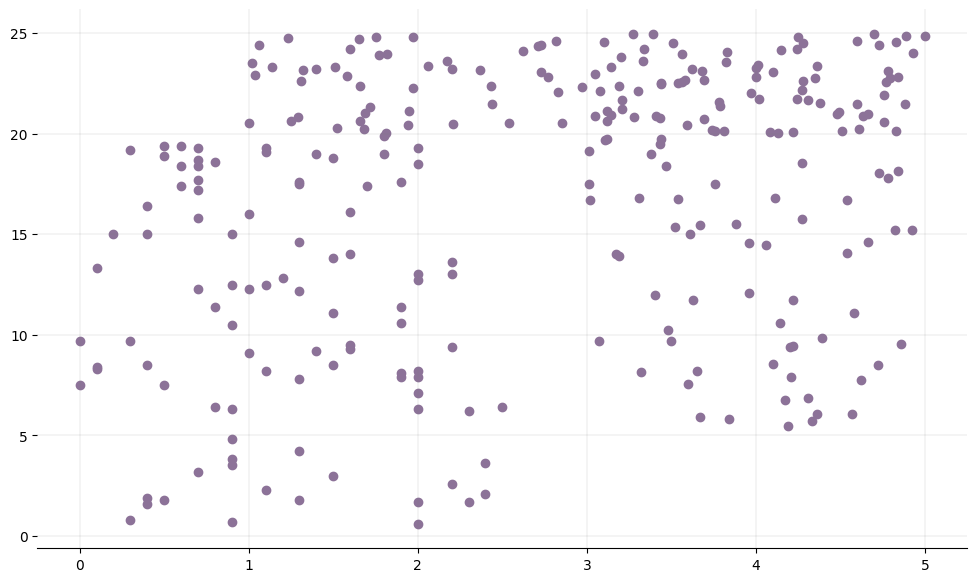

In [219]:
def generate_random_dataset(size):
    """ Generate a random dataset and that follows a quadratic  distribution
    """
    x = []
    y = []
    target = []
    random.seed(301) #obvious SML 301 adaptation
    for i in range(size):
        # class zero
        x.append(np.round(random.uniform(0, 2.5), 1))
        y.append(np.round(random.uniform(0, 20), 1))
        target.append(0)        # class one
        x.append(np.round(random.uniform(1, 5), 2))
        y.append(np.round(random.uniform(20, 25), 2))
        target.append(1)
        x.append(np.round(random.uniform(3, 5), 2))
        y.append(np.round(random.uniform(5, 25), 2))
        target.append(1)

    df_x = pd.DataFrame(data=x)
    df_y = pd.DataFrame(data=y)
    df_target = pd.DataFrame(data=target)
    data_frame = pd.concat([df_x, df_y], ignore_index=True, axis=1)
    data_frame = pd.concat([data_frame, df_target], ignore_index=True, axis=1)
    data_frame.columns = ['x', 'y', 'target']
    return data_frame

# Generate dataset
size = 100
dataset = generate_random_dataset(size)
features = dataset[['x', 'y']]
label = dataset['target']

# Hold out 20% of the dataset for training
test_size = int(np.round(size * 0.2, 0))

# Split dataset into training and testing sets
x_train = features[:-test_size].values
y_train = label[:-test_size].values
x_test = features[-test_size:].values
y_test = label[-test_size:].values

# Plotting the training set
fig, ax = plt.subplots(figsize=(12, 7))# removing to and right border
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)# adding major gridlines
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
ax.scatter(features[:-test_size]['x'], features[:-test_size]['y'], color="#8C7298")

plt.show()

## Linear Kernel

In [220]:
model = svm.SVC(kernel='linear')
model.fit(x_train, y_train)

,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


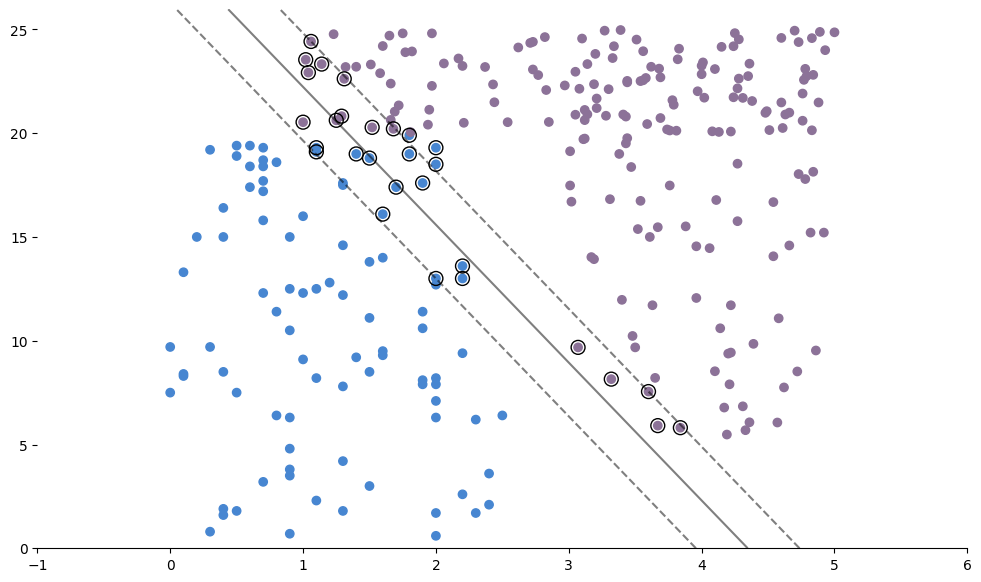

In [221]:
fig, ax = plt.subplots(figsize=(12, 7))

# Removing to and right border
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# Create grid to evaluate model
xx = np.linspace(-1, max(features['x']) + 1, len(x_train))
yy = np.linspace(0, max(features['y']) + 1, len(y_train))
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

train_size = len(features[:-test_size]['x'])

# Assigning different colors to the classes
colors = y_train
colors = np.where(colors == 1, '#8C7298', '#4786D1')

# Plot the dataset
ax.scatter(features[:-test_size]['x'], features[:-test_size]['y'], c=colors)

# Get the separating hyperplane
Z = model.decision_function(xy).reshape(XX.shape)

# Draw the decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

# Highlight support vectors with a circle around them
ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100, linewidth=1, facecolors='none', edgecolors='k')
plt.show()

In [222]:
model_predictions = model.predict(x_test)
model_accuracy = accuracy_score(y_test, model_predictions)
print("Accuracy (normalized): " + str(model_accuracy))

Accuracy (normalized): 0.95


## Polynomial Kernel

### Degree 2

* notice the `degree` parameter

In [223]:
model = svm.SVC(kernel = 'poly', degree = 2)
model.fit(x_train, y_train)

,C,1.0
,kernel,'poly'
,degree,2
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


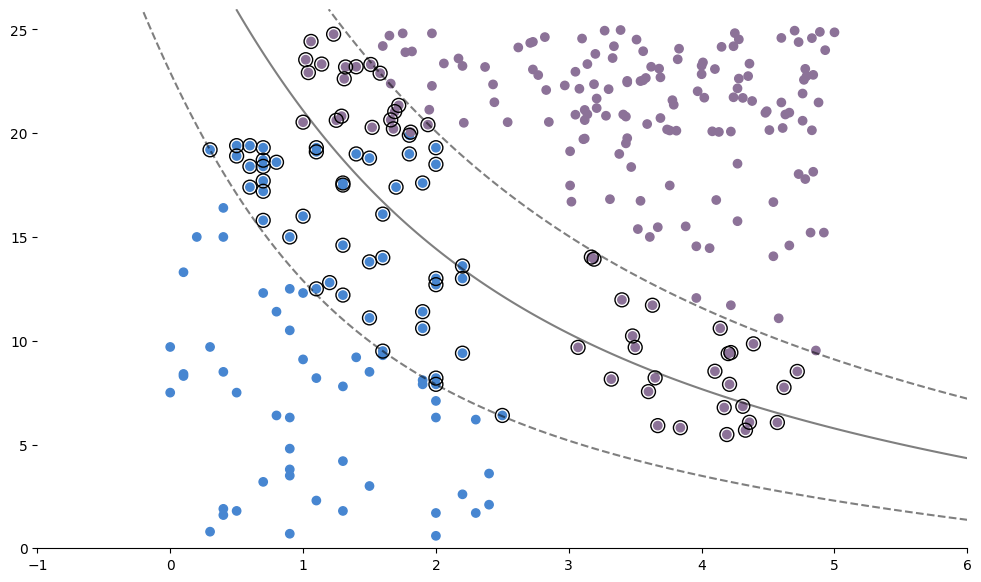

In [224]:
fig, ax = plt.subplots(figsize=(12, 7))

# Removing to and right border
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# Create grid to evaluate model
xx = np.linspace(-1, max(features['x']) + 1, len(x_train))
yy = np.linspace(0, max(features['y']) + 1, len(y_train))
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

train_size = len(features[:-test_size]['x'])

# Assigning different colors to the classes
colors = y_train
colors = np.where(colors == 1, '#8C7298', '#4786D1')

# Plot the dataset
ax.scatter(features[:-test_size]['x'], features[:-test_size]['y'], c=colors)

# Get the separating hyperplane
Z = model.decision_function(xy).reshape(XX.shape)

# Draw the decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

# Highlight support vectors with a circle around them
ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100, linewidth=1, facecolors='none', edgecolors='k')
plt.show()

In [225]:
model_predictions = model.predict(x_test)
model_accuracy = accuracy_score(y_test, model_predictions)
print("Accuracy (normalized): " + str(model_accuracy))

Accuracy (normalized): 0.7


### Degree 3

* also exploring the `cost` parameter $C$

In [226]:
model = svm.SVC(C = 0.5, kernel = 'poly', degree = 3)
model.fit(x_train, y_train)

,C,0.5
,kernel,'poly'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


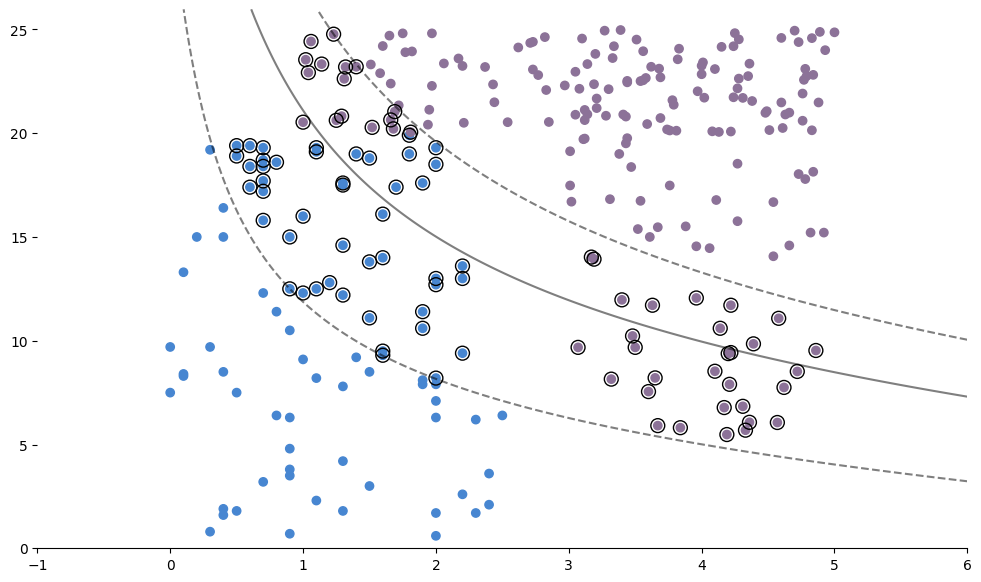

In [227]:
fig, ax = plt.subplots(figsize=(12, 7))

# Removing to and right border
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# Create grid to evaluate model
xx = np.linspace(-1, max(features['x']) + 1, len(x_train))
yy = np.linspace(0, max(features['y']) + 1, len(y_train))
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

train_size = len(features[:-test_size]['x'])

# Assigning different colors to the classes
colors = y_train
colors = np.where(colors == 1, '#8C7298', '#4786D1')

# Plot the dataset
ax.scatter(features[:-test_size]['x'], features[:-test_size]['y'], c=colors)

# Get the separating hyperplane
Z = model.decision_function(xy).reshape(XX.shape)

# Draw the decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

# Highlight support vectors with a circle around them
ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100, linewidth=1, facecolors='none', edgecolors='k')
plt.show()

In [228]:
model_predictions = model.predict(x_test)
model_accuracy = accuracy_score(y_test, model_predictions)
print("Accuracy (normalized): " + str(model_accuracy))

Accuracy (normalized): 0.7


# Cross Validation

In [215]:
grid = skm.GridSearchCV(estimator = svm.SVC(),
                        param_grid = {'C':[0.01, 0.1, 1.0, 10], 'kernel':['poly'], 'degree':[2,3,4]},
                        #param_grid = {'C':np.linspace(0.01, 10, 10), 'kernel':['poly'], 'degree':[2,3,4]},
                        cv = 5,
                        scoring='accuracy');
grid.fit(x_train , y_train)

,estimator,SVC()
,param_grid,"{'C': [0.01, 0.1, ...], 'degree': [2, 3, ...], 'kernel': ['poly']}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,10


In [216]:
# display best parameters from the gride search
print(grid.best_estimator_)

SVC(C=10, degree=2, kernel='poly')


In [229]:
model = svm.SVC(C = 10.0, kernel = 'poly', degree = 2)
model.fit(x_train, y_train)
model_predictions = model.predict(x_test)
model_accuracy = accuracy_score(y_test, model_predictions)
print("Accuracy (normalized): " + str(model_accuracy))

Accuracy (normalized): 0.85


# Radial Basis Kernel

In [ ]:
model = svm.SVC(C = 0.5, kernel = 'rbf', gamma = 0.301)
model.fit(x_train, y_train)

,C,0.5
,kernel,'rbf'
,degree,3
,gamma,0.301
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


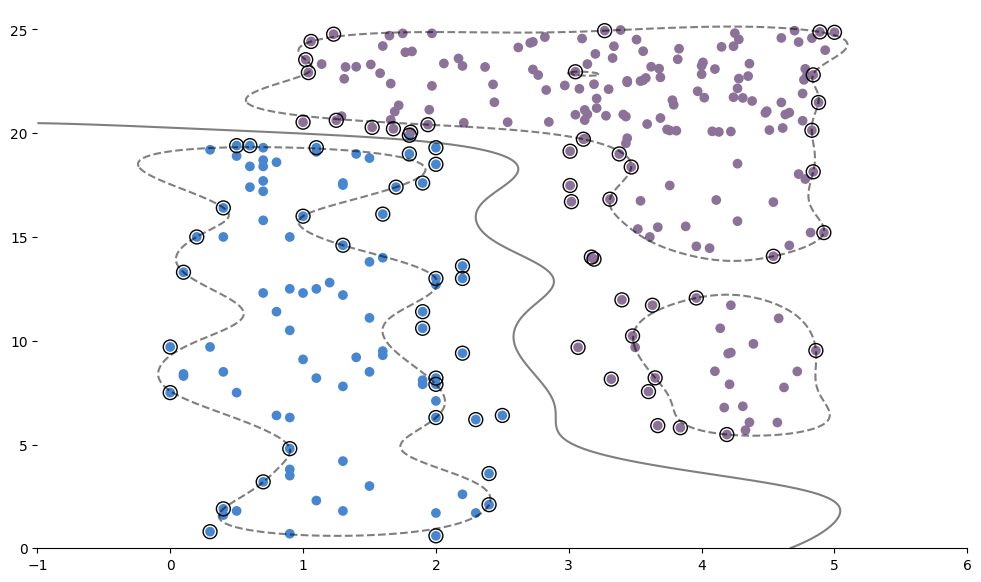

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7))

# Removing to and right border
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# Create grid to evaluate model
xx = np.linspace(-1, max(features['x']) + 1, len(x_train))
yy = np.linspace(0, max(features['y']) + 1, len(y_train))
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

train_size = len(features[:-test_size]['x'])

# Assigning different colors to the classes
colors = y_train
colors = np.where(colors == 1, '#8C7298', '#4786D1')

# Plot the dataset
ax.scatter(features[:-test_size]['x'], features[:-test_size]['y'], c=colors)

# Get the separating hyperplane
Z = model.decision_function(xy).reshape(XX.shape)

# Draw the decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

# Highlight support vectors with a circle around them
ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100, linewidth=1, facecolors='none', edgecolors='k')
plt.show()

In [ ]:
model_predictions = model.predict(x_test)
model_accuracy = accuracy_score(y_test, model_predictions)
print("Accuracy (normalized): " + str(model_accuracy))

Accuracy (normalized): 1.0


In [ ]:
grid = skm.GridSearchCV(estimator = svm.SVC(),
                        param_grid = {'C':np.logspace(-2, 1, 10),
                                      'gamma':np.logspace(-2, 1, 10),
                                      'kernel':['rbf']},
                        cv = 4,
                        scoring='accuracy');
grid.fit(x_train , y_train)

,estimator,SVC()
,param_grid,"{'C': array([ 0.01 ... 10. ]), 'gamma': array([ 0.01 ... 10. ]), 'kernel': ['rbf']}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,4
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,np.float64(0....4346900318834)


In [ ]:
# display best parameters from the gride search
print(grid.best_estimator_)

SVC(C=np.float64(0.21544346900318834), gamma=np.float64(0.46415888336127775))


In [ ]:
model = svm.SVC(C = 0.21544346900318834, kernel = 'rbf', gamma = 0.46415888336127775)
model.fit(x_train, y_train)

,C,0.21544346900318834
,kernel,'rbf'
,degree,3
,gamma,0.46415888336127775
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [ ]:
model_predictions = model.predict(x_test)
model_accuracy = accuracy_score(y_test, model_predictions)
print("Accuracy (normalized): " + str(model_accuracy))

Accuracy (normalized): 1.0


# Bias-Variance Trade-Off

## demo by Neri Van Otten

https://spotintelligence.com/2023/04/11/bias-variance-trade-off/

In [ ]:
# Generate synthetic data
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=0, random_state=42)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a range of values for the regularization parameter C to search over
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

# Create a grid search object to search over hyperparameters
grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found by the grid search
print("Best hyperparameters:", grid_search.best_params_)

# Evaluate the model on the test data
svm = grid_search.best_estimator_
print("Test accuracy:", svm.score(X_test, y_test))

Best hyperparameters: {'C': 10}
Test accuracy: 0.89


# Gradient Descent

* adapted from demo by Mirko Stojiljkovic
* https://realpython.com/gradient-descent-algorithm-python/


In [10]:
# idea (partial code)
# def gradient_descent(gradient, start, learn_rate, n_iter):
#     vector = start
#     for _ in range(n_iter):
#        diff = -learn_rate * gradient(vector)
#        vector += diff
#     return vector

## Converence

* need: termination condition(s)
* want: display iteration results

In [11]:
def gradient_descent(gradient, start, learn_rate, n_iter=50, tolerance=1e-06):
    vector = start
    for iter_num in range(n_iter):
        diff = -learn_rate * gradient(vector)
        if np.all(np.abs(diff) <= tolerance):
            break

        print("iteration: " + str(iter_num))
        print("current guess: ", vector)

        vector += diff
    return vector

## Example

We will find local minima for

$$f(x) = x^{4} - 5x^{2} - 3x$$

* observe: $f'(x) = 4x^{3} - 10x - 3$
* tip: try out different starting locations and different learning rates

In [12]:
f = lambda x: x**4 - 5*x**2 - 3*x
f_prime = lambda x: 4*x**3 - 10*x - 3
gradient_descent(f_prime, start = 0.301, learn_rate = 0.301)

iteration: 0
current guess:  0.301
iteration: 1
current guess:  2.077175835196
iteration: 2
current guess:  -1.558141743024473
iteration: 3
current guess:  -0.7905784579777443
iteration: 4
current guess:  -1.672295717010838
iteration: 5
current guess:  -0.17216264696601957
iteration: 6
current guess:  0.21877167353158977
iteration: 7
current guess:  1.767667759167257
iteration: 8
current guess:  1.3412441409070421
iteration: 9
current guess:  3.376363161185013
iteration: 10
current guess:  -31.89969552212498
iteration: 11
current guess:  38955.82392653197
iteration: 12
current guess:  -71177653837903.53
iteration: 13
current guess:  4.34167682027791e+41


OverflowError: (34, 'Result too large')

## Example

We will find local minima for

$$f(x,y) = x^{2} + y^{4}$$

* observe $\nabla f = (2x, 4y^{3})$
* tip: try out different starting locations and different learning rates

In [13]:
f_prime = lambda x: 2*x[0] + 4*x[1]**3
gradient_descent(f_prime, start = np.array([0.301, 0.301]), learn_rate = 0.301)

iteration: 0
current guess:  [0.301 0.301]
iteration: 1
current guess:  [0.08696384 0.08696384]
iteration: 2
current guess:  [0.03381976 0.03381976]
iteration: 3
current guess:  [0.01341369 0.01341369]
iteration: 4
current guess:  [0.00533574 0.00533574]
iteration: 5
current guess:  [0.00212344 0.00212344]
iteration: 6
current guess:  [0.00084512 0.00084512]
iteration: 7
current guess:  [0.00033636 0.00033636]
iteration: 8
current guess:  [0.00013387 0.00013387]
iteration: 9
current guess:  [5.32801947e-05 5.32801947e-05]
iteration: 10
current guess:  [2.12055173e-05 2.12055173e-05]
iteration: 11
current guess:  [8.43979589e-06 8.43979589e-06]
iteration: 12
current guess:  [3.35903876e-06 3.35903876e-06]


array([1.33689743e-06, 1.33689743e-06])

## Example: Linear Regression

Synthetic data from $y = 301x + 42 + N(0,1)$

In [14]:
x = np.linspace(1, 100, 100)
y = 301*x + 42 + np.random.normal(0, 1, size = 100)

def gradient_descent_OLS(
    gradient, x, y, start, learn_rate=0.1, n_iter=50, tolerance=1e-06
    ):
    vector = start
    for _ in range(n_iter):
        diff = -learn_rate * np.array(gradient(x, y, vector))
        if np.all(np.abs(diff) <= tolerance):
            break
        vector += diff
    return vector

def ssr_gradient(x, y, b):
    res = b[0] + b[1] * x - y
    return res.mean(), (res * x).mean()  # .mean() is a method of np.ndarray

In [15]:
gradient_descent_OLS(ssr_gradient, x, y,
                     start = [0.301, 0.301],
                     learn_rate = 0.0005,
                     n_iter = 100000)

array([ 41.79000319, 301.00126296])

# Stochastic Gradient Descent

* calculations in *batches*

In [16]:
def sgd(
    gradient, x, y, n_vars=None, start=None, learn_rate=0.1,
    decay_rate=0.0, batch_size=1, n_iter=50, tolerance=1e-06,
    dtype="float64", random_state=None
):
    # Checking if the gradient is callable
    if not callable(gradient):
        raise TypeError("'gradient' must be callable")

    # Setting up the data type for NumPy arrays
    dtype_ = np.dtype(dtype)

    # Converting x and y to NumPy arrays
    x, y = np.array(x, dtype=dtype_), np.array(y, dtype=dtype_)
    n_obs = x.shape[0]
    if n_obs != y.shape[0]:
        raise ValueError("'x' and 'y' lengths do not match")
    xy = np.c_[x.reshape(n_obs, -1), y.reshape(n_obs, 1)]

    # Initializing the random number generator
    seed = None if random_state is None else int(random_state)
    rng = np.random.default_rng(seed=seed)

    # RANDOM INITIALIZATION
    vector = (
        rng.normal(size=int(n_vars)).astype(dtype_)
        if start is None else
        np.array(start, dtype=dtype_)
    )

    # Setting up and checking the learning rate
    learn_rate = np.array(learn_rate, dtype=dtype_)
    if np.any(learn_rate <= 0):
        raise ValueError("'learn_rate' must be greater than zero")

    # Setting up and checking the decay rate
    decay_rate = np.array(decay_rate, dtype=dtype_)
    if np.any(decay_rate < 0) or np.any(decay_rate > 1):
        raise ValueError("'decay_rate' must be between zero and one")

    # Setting up and checking the size of minibatches
    batch_size = int(batch_size)
    if not 0 < batch_size <= n_obs:
        raise ValueError(
            "'batch_size' must be greater than zero and less than "
            "or equal to the number of observations"
        )

    # Setting up and checking the maximal number of iterations
    n_iter = int(n_iter)
    if n_iter <= 0:
        raise ValueError("'n_iter' must be greater than zero")

    # Setting up and checking the tolerance
    tolerance = np.array(tolerance, dtype=dtype_)
    if np.any(tolerance <= 0):
        raise ValueError("'tolerance' must be greater than zero")

    # Setting the difference to zero for the first iteration
    diff = 0

    # Performing the gradient descent loop
    for _ in range(n_iter):
        # Shuffle x and y
        rng.shuffle(xy)

        # Performing minibatch moves
        for start in range(0, n_obs, batch_size):
            stop = start + batch_size
            x_batch, y_batch = xy[start:stop, :-1], xy[start:stop, -1:]

            # Recalculating the difference
            grad = np.array(gradient(x_batch, y_batch, vector), dtype_)
            diff = decay_rate * diff - learn_rate * grad

            # Checking if the absolute difference is small enough
            if np.all(np.abs(diff) <= tolerance):
                break

            # Updating the values of the variables
            vector += diff

    return vector if vector.shape else vector.item()

In [17]:
sgd(ssr_gradient, x, y,
    start = [0.301, 0.301],
    learn_rate = 0.0005,
    batch_size = 5,
    n_iter = 1000,
    random_state = 301)

array([ 38.90778058, 301.08851941])